In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
from speculator import Photulator
import fsps
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
filter_list = fsps.find_filter('lsst')
print(filter_list)

['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']


In [5]:
#training data
spsparams = np.load("training_data/sps_parameters_51000000.npy")[:1000000].astype(np.float32)
photometry = np.load("training_data/photometry_51000000.npy")[:1000000].astype(np.float32)
print(spsparams.shape, photometry.shape)

# parameters shift and scale
parameters_shift = np.mean(spsparams, axis=0)
parameters_scale = np.std(spsparams, axis=0)
magnitudes_shift = np.mean(photometry, axis=0)
magnitudes_scale = np.std(photometry, axis=0)

(1000000, 17) (1000000, 6)


In [6]:
#select filters
select = 0
filters = filter_list[select:select+1]
training_theta = tf.convert_to_tensor(spsparams)
training_mag = tf.convert_to_tensor(photometry[:,select:select+1])
print(filter)

# training set up
validation_split = 0.1

#STEP SIZE (len(lr) = len(batch_size))
lr = [1e-3, 1e-4, 1e-5, 1e-5]

#BIGGER BATCH -> BETTER ESTIMATE OF GRADIENT BUT MORE MEMORY REQUIRED AND SLOWER (REMEMBER: NETWORK ONLY UPDATES PER BATCH)
#                                                                                    -A BIGGER BATCH MEANS YOU WILL LOOP THROUGH DATA QUICKER
#                                                                                     -NEED MORE EPOCHS
# doing large batches last to check it doesnt crazy impact the validation loss? Do most of the work with small batches which is faster?
batch_size = [1000, 10000, 30000, int((1-validation_split) * training_theta.shape[0])]

#how many minibatches to split into?
gradient_accumulation_steps = [1, 1, 1, 10]#, 1, 10]

if(len(lr) != len(batch_size) or 
   len(lr) != len(gradient_accumulation_steps) or
     len(batch_size) != len(gradient_accumulation_steps)):
    raise Exception("miss matched size of lr/batch_size/gradient_acc") 

# early stopping set up
patience = 2

# architecture
n_layers = 4
n_units = 128

#extra params
verbose = True
disable_early_stopping=True

#optimiser
optimiser = tf.keras.optimizers.legacy.Adam()

#running loss
running_loss = []
running_val_loss = [] #keeps track of validation loss across different batch sizes/learning rates

<class 'filter'>


In [7]:
# architecture
n_hidden = [n_units]*n_layers

# train each band in turn
for f in range(len(filters)):

    if verbose is True:
        print('filter ' + filters[f] + '...')

    # construct the PHOTULATOR model
    photulator = Photulator(n_parameters=training_theta.shape[-1], 
                        filters=[filters[f]], 
                        parameters_shift=parameters_shift, 
                        parameters_scale=parameters_scale, 
                        magnitudes_shift=magnitudes_shift[f], 
                        magnitudes_scale=magnitudes_scale[f], 
                        n_hidden=n_hidden, 
                        restore=False, 
                        restore_filename=None,
                        optimizer=optimiser)

    # train using cooling/heating schedule for lr/batch-size
    for i in range(len(lr)):
        
        if verbose is True:
            print('learning rate = ' + str(lr[i]) + ', batch size = ' + str(batch_size[i]))

        # set learning rate
        photulator.optimizer.lr = lr[i]

        # split into validation and training sub-sets
        n_validation = int(training_theta.shape[0] * validation_split)
        n_training = training_theta.shape[0] - n_validation
        training_selection = tf.random.shuffle([True] * n_training + [False] * n_validation)

        # create iterable dataset (given batch size)
        train_mag = tf.expand_dims(training_mag[:,f],-1)
        training_data = tf.data.Dataset.from_tensor_slices((training_theta[training_selection], train_mag[training_selection])).shuffle(n_training).batch(batch_size[i])

        # set up training loss
        training_loss = [np.infty]
        validation_loss = [np.infty]
        best_loss = np.infty
        early_stopping_counter = 0

        # loop over epochs
        while early_stopping_counter < patience:

            # loop over batches for a single epoch 
            #for loop:(give one batch of param+phot -> update network once)
            for theta, mag in training_data:

                # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
                if gradient_accumulation_steps[i] == 1:
                    loss = photulator.training_step(theta, mag)
                else:
                    #FURTHER BATCHING of batch into sub-batch as not to calculate the gradients all in one step, instead calculate them in smaller sub-batches
                    #but then still update the model in one batch (not sub-batches) as you have all the gradients, just 'acculumlated' to save memory
                    loss = photulator.training_step_with_accumulated_gradients(theta, mag, accumulation_steps=gradient_accumulation_steps[i])

                running_loss.append(loss)
                #print(loss)

            # compute total loss and validation loss
            validation_loss.append(np.array(photulator.compute_loss(training_theta[~training_selection], train_mag[~training_selection]).numpy()))

            # early stopping condition
            # if validation loss keeps going down, reset stopping counter
            if validation_loss[-1] < best_loss:
                best_loss = validation_loss[-1]
                early_stopping_counter = 0
            #else, if validation loss goes back up again, increment counter
            else:
                early_stopping_counter += 1

            #when counter reaches patience, save model(the larger patience, the more epochs in a row the validation loss needs to be same or increasing)
            if early_stopping_counter >= patience:
                photulator.update_emulator_parameters()
                photulator.save('model_{}x{}'.format(n_layers, n_units) + filters[f])
                if verbose is True:
                    print('Validation loss = ' + str(best_loss))
                running_val_loss.append(validation_loss)

filter lsst_u...
learning rate = 0.001, batch size = 1000
Validation loss = 2.7268374
learning rate = 0.0001, batch size = 10000


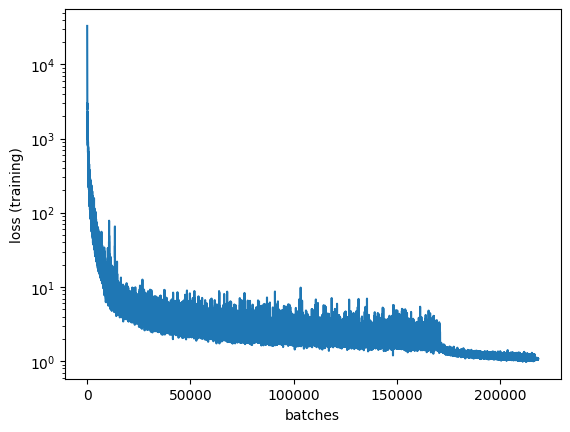

In [ ]:
plt.plot(running_loss)
plt.ylabel('loss (training)')
plt.xlabel('batches')
plt.yscale("log")

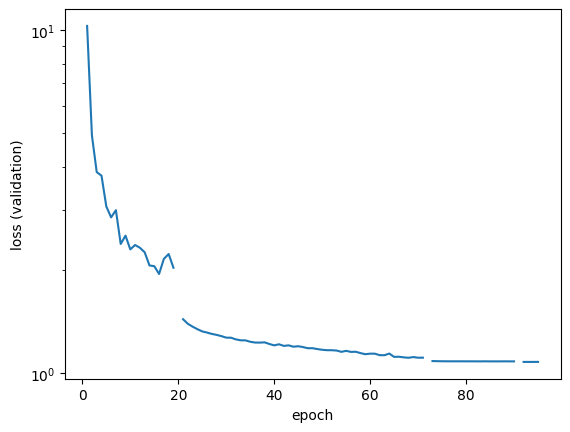

In [ ]:
plt.plot(np.hstack(running_val_loss))
plt.ylabel('loss (validation)')
plt.xlabel('epoch')
plt.yscale("log")